### **Section 1 – Introduction & Motivation**

**Purpose**

In this notebook, we shift our focus from *training* and *reconstruction* (as in previous notebooks) to *exploration and interpretation* of what the **Variational Autoencoder (VAE)** has learned.  
We’ll examine whether the model has captured meaningful, structured representations of human emotions in its **latent space**.

**Conceptual Recap**

So far, we have:
- **Built and trained** both Autoencoders (AEs) and Variational Autoencoders (VAEs).  
- Observed that VAEs introduce *probabilistic latent variables* — each image is encoded not to a fixed vector, but to a **distribution** parameterized by mean $ \mu $ and variance $ \sigma^2 $.  
- Understood that this design allows **sampling** and **generation** of new examples, not just reconstruction.

Now, we’ll explore *what lies inside* this learned latent space:
- Are emotions arranged meaningfully (e.g., “happy” near “neutral”)?
- Can we move *smoothly* from one emotion to another by interpolating between latent vectors?
- How does this differ from the deterministic latent space of a regular AE?

**Notebook Overview**

| Section | Focus |
|:--------|:------|
| 2 | Load trained models and prepare data |
| 3 | Encode faces into latent space (μ vectors) |
| 4 | Visualize latent structure using PCA/t-SNE |
| 5 | Perform emotion interpolation in latent space |
| 6 | Compare AE vs. VAE latent representations |
| 7–8 | Reflect on emotion continuum and real-world implications |

**Key Question**
> 💡 *Does the VAE learn a latent space that reflects the natural structure of human emotions — continuous, smooth, and meaningful?*

**Code: Load Trained Models**

We’ll start by importing the necessary modules and loading the trained models we saved in **NB03** (`vae_model.pth` and optionally `ae_model.pth`).  
If you haven’t saved them yet, please return to NB03 and ensure the models are saved after training.

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# --- Load FER2013-small dataset ---
data = np.load("fer2013_small.npz")
X, y = data["X"], data["y"]

print(f"Dataset loaded: {X.shape[0]} samples, shape {X.shape[1:]}")

# Convert to torch tensor for encoding later
X_t = torch.tensor(X, dtype=torch.float32).view(X.shape[0], -1)

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Define VAE model architecture ---
class VAE(nn.Module):
    def __init__(self, latent_dim=32):  # match NB03
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 512)
        self.fc5 = nn.Linear(512, 2304)
        
        # Activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        h4 = self.relu(self.fc4(h3))
        return self.sigmoid(self.fc5(h4))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
# --- Load pre-trained model ---
vae_model = VAE(latent_dim=32).to(device)
vae_model.load_state_dict(torch.load("vae_model.pth", map_location=device))
vae_model.eval()
print("✅ Correct VAE loaded successfully.")

Dataset loaded: 8257 samples, shape (48, 48)


C:\Users\noman\AppData\Local\Temp\ipykernel_10840\3007876971.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("vae_model.pth", map_l

✅ Correct VAE loaded successfully.


At this point, we have:
- Loaded both the dataset and the trained models.
- Set up our environment to explore how the VAE internally organizes emotions.

This sets the stage for the next section, where we’ll encode facial images into latent vectors and start visualizing their structure.

> 🧭 We are moving from reconstruction to interpretation — exploring what the network “believes” about human emotions.

---

### **2. Load Models and Data**

In this section, we reuse our **trained models** and the **FER2013-small** dataset so we can explore the latent space without retraining.  
We will (1) ensure reproducibility and GPU compatibility, (2) load the downsampled dataset and build validation tensors, and (3) load the **VAE** (and **AE** if available) using the **same architecture as NB03** so the weights match.

> We will reuse the exact NB03 VAE architecture (including layer names and latent dimension) to maintain consistent latent space interpretation.

**Setup: Reproducibility, Device**

In [42]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


**Load FER2013-small and Prepare Validation Tensors**

In [43]:
# Load the downsampled dataset saved earlier
data = np.load("fer2013_small.npz")
X, y = data["X"], data["y"]          # X: (N, 48, 48) in [0,1], y: (N,)

# Train/Validation split (stratified to preserve class proportions)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Torch tensors: we will encode flattened vectors for the (fully-connected) VAE
X_val_t = torch.tensor(X_val, dtype=torch.float32).view(X_val.shape[0], -1)  # (N, 2304)

print(f"✅ Data loaded. Train: {X_train.shape}, Val: {X_val.shape}")


✅ Data loaded. Train: (7018, 48, 48), Val: (1239, 48, 48)


**Recreate NB03 VAE Architecture (to Match Saved Weights)**

In NB03, we used a latent dimension of 32 and decoder layers fc3 → fc4 → fc5.

We must recreate the exact same class definition so vae_model.pth loads without key mismatches.

In [44]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):  # match NB03
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 512)
        self.fc5 = nn.Linear(512, 2304)
        # Activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        h4 = self.relu(self.fc4(h3))
        return self.sigmoid(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


**Load Trained Models (VAE Mandatory, AE Optional)**

In [45]:
# Load trained VAE (NB03 checkpoint)
vae_model = VAE(latent_dim=32).to(device)
vae_model.load_state_dict(torch.load("vae_model.pth", map_location=device))
vae_model.eval()
print("✅ Loaded trained VAE (latent_dim=32).")

# Optional: load AE for later comparison if you saved it as ae_model.pth
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 2304),
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

try:
    ae_model = Autoencoder().to(device)
    ae_model.load_state_dict(torch.load("ae_model.pth", map_location=device))
    ae_model.eval()
    print("✅ Loaded trained AE (optional).")
except Exception as e:
    print("ℹ️ AE checkpoint not found; we will proceed with VAE-only analysis.")


C:\Users\noman\AppData\Local\Temp\ipykernel_10840\2568026703.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("vae_model.pth", map_lo

✅ Loaded trained VAE (latent_dim=32).
✅ Loaded trained AE (optional).


> With models and data ready, we can now encode faces into the VAE’s latent space and start visualizing its geometry and semantics in the next section.

---

### **3. Encoding Faces into Latent Space**

Now that our trained model and dataset are ready, we will **encode each face image** into its **latent representation** — specifically, its mean vector **μ**.  
These vectors represent how the VAE "understands" the structure of each face in a compressed, abstract form.

**Purpose**

To project the input faces into the latent space learned by the VAE.  
Each face will be represented by its latent mean vector `μ`, which captures its most salient emotional and structural features.

**Encode Validation Faces into Latent Mean Vectors**

In [46]:
vae_model.eval()

all_mu = []
all_labels = []

with torch.no_grad():
    for i in range(0, len(X_val_t), 128):
        batch = X_val_t[i:i+128].to(device)
        mu, logvar = vae_model.encode(batch)
        all_mu.append(mu.cpu())
        all_labels.append(torch.tensor(y_val[i:i+128]))

# Concatenate all batches
mu_all = torch.cat(all_mu)
labels_all = torch.cat(all_labels)

print(f"✅ Encoded {mu_all.shape[0]} faces into latent space.")
print(f"Latent vector shape: {mu_all.shape[1]} dimensions")


✅ Encoded 1239 faces into latent space.
Latent vector shape: 32 dimensions


**Preview a Few Latent Vectors**

In [47]:
# Display first 5 μ vectors
for i in range(5):
    print(f"Sample {i} | Emotion label: {labels_all[i].item()} | μ[:5]: {mu_all[i, :5].numpy()}")


Sample 0 | Emotion label: 0 | μ[:5]: [-0.73990554  0.87906665 -0.16372275 -1.6683102   3.9541411 ]
Sample 1 | Emotion label: 4 | μ[:5]: [-0.7323944   0.51517045 -0.3496175  -0.6473472   2.2844594 ]
Sample 2 | Emotion label: 0 | μ[:5]: [-0.631611   1.0247294 -1.0803151 -1.591857   3.1752841]
Sample 3 | Emotion label: 6 | μ[:5]: [-0.88486826  0.77146184 -0.7900158  -0.7840321   2.6167252 ]
Sample 4 | Emotion label: 5 | μ[:5]: [-0.03839552  0.9625607  -0.6356392  -2.2034833   2.9469635 ]


**Reflection**

Each vector μ is a compact summary of an entire facial image.</br>
Unlike the pixel space (48×48 = 2304 dimensions), the latent space (here, 32D) captures conceptual regularities — patterns like smiling, frowning, or surprise — in a continuous form.

These representations will now serve as the foundation for:

- visualizing latent clusters by emotion (Section 4), and
- interpolating between emotions to explore facial transitions (Section 5).

> In essence, we’ve transformed high-dimensional pixel data into a “semantic coordinate system” for faces — a psychological space where nearby points correspond to similar expressions.

---

### **4. Visualizing Latent Space (2D Projection)**

We now reveal how emotions are organized in the **VAE latent space** by projecting the latent mean vectors (μ) to 2D and **coloring points by emotion class**.

> Expect to see clusters where “happy” might group more distinctly, while “neutral” overlaps others — a sign of **smooth, continuous** representation rather than hard class boundaries.

**Project μ to 2D via PCA or t-SNE**

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Ensure we have mu_all (N, latent_dim) and labels_all (N,)
try:
    mu_all, labels_all
except NameError:
    # Fallback: compute μ for the validation set
    vae_model.eval()
    all_mu, all_labels = [], []
    with torch.no_grad():
        for i in range(0, len(X_val_t), 128):
            batch = X_val_t[i:i+128].to(device)
            mu, logvar = vae_model.encode(batch)
            all_mu.append(mu.cpu())
            all_labels.append(torch.tensor(y_val[i:i+128]))
    mu_all = torch.cat(all_mu)
    labels_all = torch.cat(all_labels)

Z = mu_all.numpy()
y_vis = labels_all.numpy()

# Choose projection: "pca" (fast) or "tsne" (nonlinear)
PROJECTION = "pca"  # change to "tsne" after confirming PCA works

if PROJECTION == "pca":
    Z2 = PCA(n_components=2, random_state=42).fit_transform(Z)
else:
    # Optional PCA pre-reduction to 30 dims for t-SNE speed/stability
    Z30 = PCA(n_components=min(30, Z.shape[1]), random_state=42).fit_transform(Z)
    Z2 = TSNE(
        n_components=2, perplexity=30, learning_rate="auto",
        init="pca", random_state=42
    ).fit_transform(Z30)


**Scatter Plot Colored by Emotion**

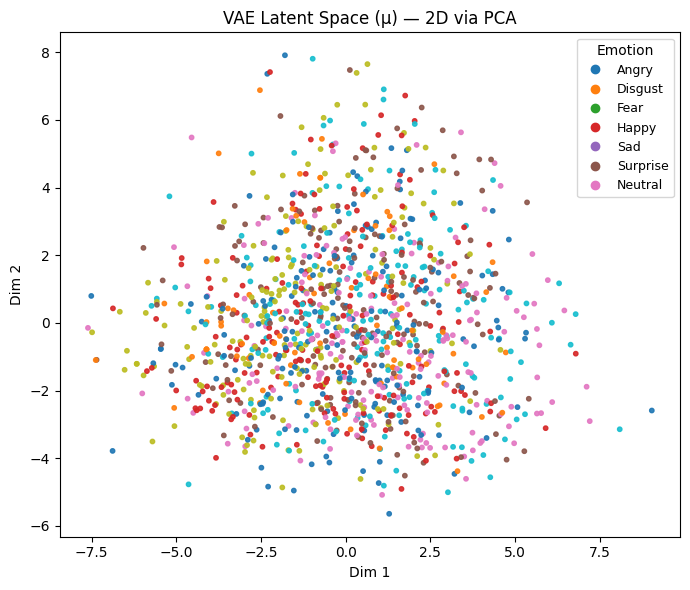

In [49]:
# FER2013 label order
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

plt.figure(figsize=(7,6))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=y_vis, s=10, cmap="tab10", alpha=0.9)
# Build legend with fixed labels
handles = []
for k, name in enumerate(emotions):
    handles.append(plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(k/10), label=name))
plt.legend(handles=handles, title="Emotion", loc="best", fontsize=9)
plt.title(f"VAE Latent Space (μ) — 2D via {PROJECTION.upper()}")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.tight_layout(); plt.show()


**Interpretation:**
- If the VAE learned meaningful structure, nearby points should reflect similar facial geometry or expression.
- “Happy” often forms a clearer region; “Neutral” overlaps multiple regions, reflecting its mid-position on an emotion continuum.

**Optional: Overlay AE Latent Space for Contrast**

If we have a trained AE loaded as ae_model, we can plot its latent embeddings alongside the VAE’s to highlight how VAEs tend to produce more continuous, Gaussian-like spaces.

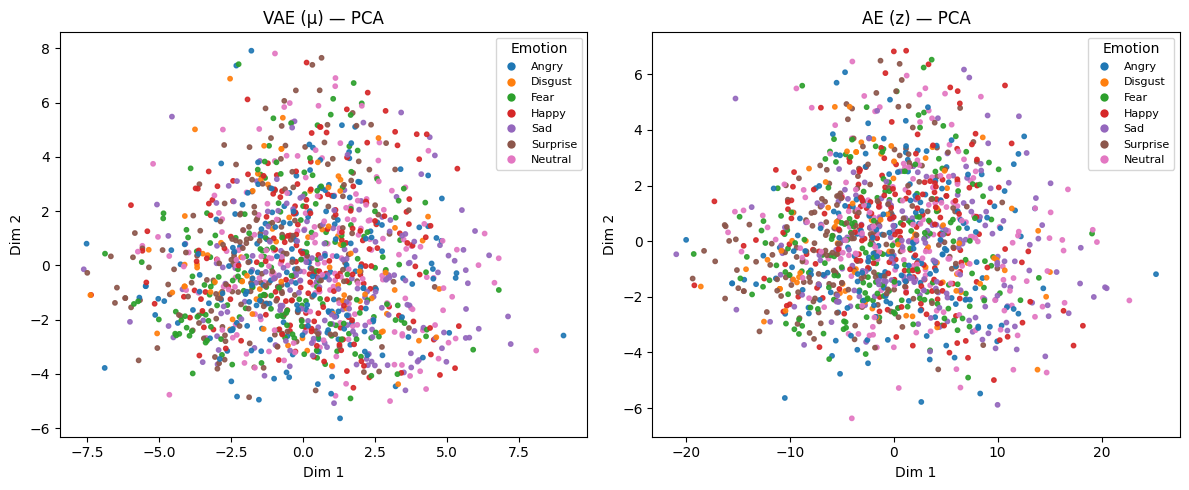

In [59]:
try:
    # Encode with AE
    ae_model.eval()
    zs = []
    with torch.no_grad():
        for i in range(0, len(X_val_t), 128):
            batch = X_val_t[i:i+128].to(device)
            _, z_ae = ae_model(batch)      # our AE forward returns (x_hat, z)
            zs.append(z_ae.cpu())
    Z_AE = torch.cat(zs).numpy()

    # Project AE embeddings with the same method
    if PROJECTION == "pca":
        Z2_AE = PCA(n_components=2, random_state=42).fit_transform(Z_AE)
    else:
        Z30_AE = PCA(n_components=min(30, Z_AE.shape[1]), random_state=42).fit_transform(Z_AE)
        Z2_AE = TSNE(
            n_components=2, perplexity=30, learning_rate="auto",
            init="pca", random_state=42
        ).fit_transform(Z30_AE)

    # --- MINIMAL FIX: discrete cmap + norm + per-axes legends ---
    import matplotlib as mpl
    from matplotlib.colors import ListedColormap
    # discrete colors from tab10, one per class id
    _base = plt.get_cmap("tab10").colors
    _colors = _base[:len(emotions)]
    _cmap = ListedColormap(_colors)
    # each integer label maps to exactly one color
    _norm = mpl.colors.BoundaryNorm(boundaries=np.arange(-0.5, len(emotions)+0.5, 1),
                                    ncolors=len(emotions))

    # Side-by-side figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

    # ---- VAE plot ----
    axes[0].scatter(Z2[:,0], Z2[:,1], c=y_vis, s=10, cmap=_cmap, norm=_norm, alpha=0.9)
    axes[0].set_title(f"VAE (μ) — {PROJECTION.upper()}")
    axes[0].set_xlabel("Dim 1"); axes[0].set_ylabel("Dim 2")
    # per-axes legend using the exact same colors
    handles0 = [plt.Line2D([], [], marker="o", linestyle="", markerfacecolor=_colors[k],
                           markeredgecolor='none', label=emotions[k]) for k in range(len(emotions))]
    axes[0].legend(handles=handles0, title="Emotion", fontsize=8, loc="best")

    # ---- AE plot ----
    axes[1].scatter(Z2_AE[:,0], Z2_AE[:,1], c=y_vis, s=10, cmap=_cmap, norm=_norm, alpha=0.9)
    axes[1].set_title(f"AE (z) — {PROJECTION.upper()}")
    axes[1].set_xlabel("Dim 1"); axes[1].set_ylabel("Dim 2")
    handles1 = [plt.Line2D([], [], marker="o", linestyle="", markerfacecolor=_colors[k],
                           markeredgecolor='none', label=emotions[k]) for k in range(len(emotions))]
    axes[1].legend(handles=handles1, title="Emotion", fontsize=8, loc="best")

    plt.tight_layout()
    plt.show()

except NameError:
    print("AE model not available — skipping AE vs VAE overlay.")


**Plotting only 2 Emotions: Fear vs Neutral and Happy vs Sad**

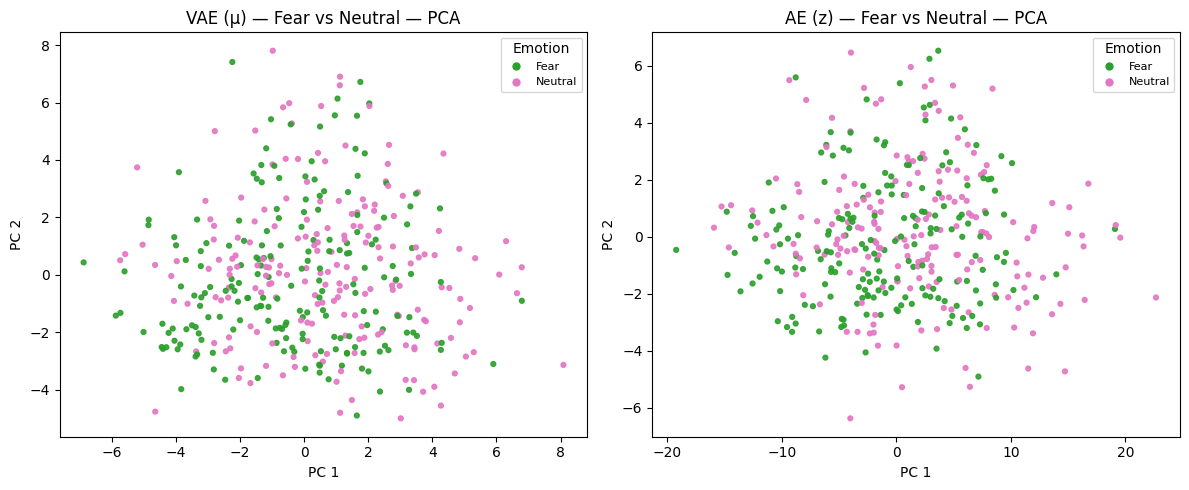

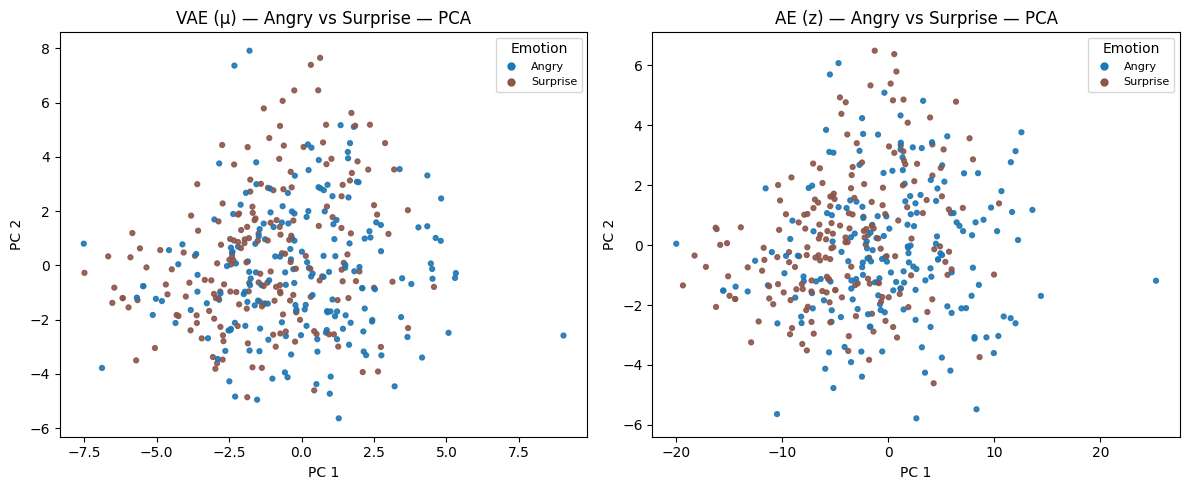

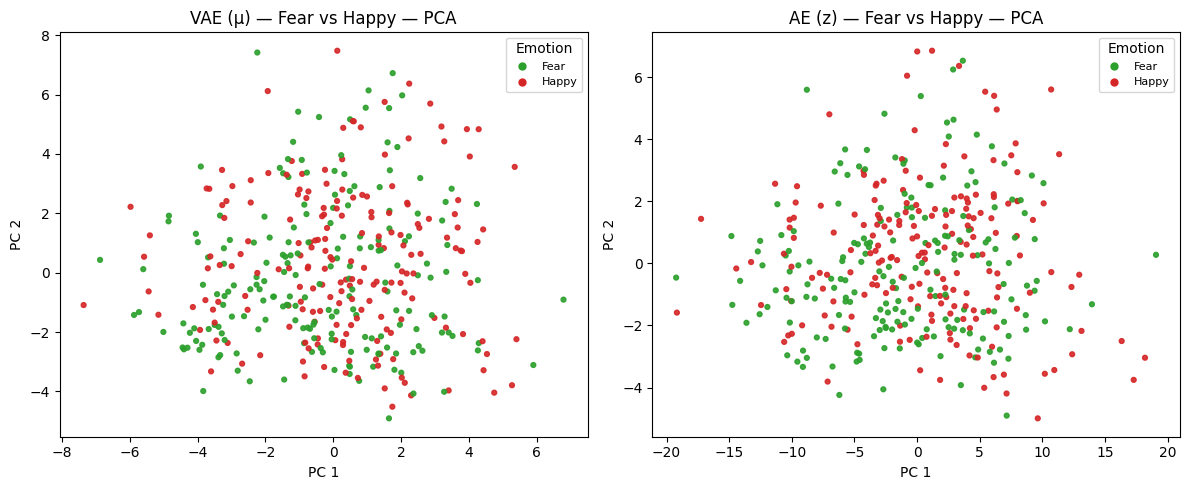

In [63]:
# --- Side-by-side PCA for selected pairs (VAE vs AE), using the SAME colors as before ---

import matplotlib as mpl
from matplotlib.colors import ListedColormap

# Reuse the same discrete cmap/norm if already defined; otherwise define them
try:
    _cmap, _norm, _colors
except NameError:
    base = plt.get_cmap("tab10").colors
    _colors = base[:len(emotions)]
    _cmap = ListedColormap(_colors)
    _norm = mpl.colors.BoundaryNorm(boundaries=np.arange(-0.5, len(emotions)+0.5, 1),
                                    ncolors=len(emotions))

# Define the pairs we want to visualize (using FER2013 indices)
pairs = [
    (2, 6, "Fear vs Neutral"),  # Fear=2, Neutral=6
    (0, 5, "Angry vs Surprise"),  # Angry=0, Surprise=5
    (2, 3, "Fear vs Happy"),      # Fear=2, Happy
]

for a, b, title in pairs:
    mask = np.isin(y_vis, [a, b])

    # Prepare per-axes legends (only the two classes in this pair)
    handles = [
        plt.Line2D([], [], marker="o", linestyle="",
                   markerfacecolor=_colors[a], markeredgecolor="none",
                   label=emotions[a]),
        plt.Line2D([], [], marker="o", linestyle="",
                   markerfacecolor=_colors[b], markeredgecolor="none",
                   label=emotions[b]),
    ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

    # VAE (μ) — PCA subset
    axes[0].scatter(Z2[mask, 0], Z2[mask, 1], c=y_vis[mask], s=12, cmap=_cmap, norm=_norm, alpha=0.9)
    axes[0].set_title(f"VAE (μ) — {title} — PCA")
    axes[0].set_xlabel("PC 1"); axes[0].set_ylabel("PC 2")
    axes[0].legend(handles=handles, title="Emotion", fontsize=8, loc="best")

    # AE (z) — PCA subset
    axes[1].scatter(Z2_AE[mask, 0], Z2_AE[mask, 1], c=y_vis[mask], s=12, cmap=_cmap, norm=_norm, alpha=0.9)
    axes[1].set_title(f"AE (z) — {title} — PCA")
    axes[1].set_xlabel("PC 1"); axes[1].set_ylabel("PC 2")
    axes[1].legend(handles=handles, title="Emotion", fontsize=8, loc="best")

    plt.tight_layout()
    plt.show()


**Narrative**

- The VAE’s probabilistic latent space encourages continuity and smooth transitions; clusters are often less fragmented than those from a deterministic AE.
- Overlap between classes is natural: many expressions share facial components and vary along continuous dimensions (e.g., valence, arousal).

> This confirms our hypothesis from earlier notebooks: the VAE learns a semantic manifold of faces. Next, we will move along this manifold deliberately via latent interpolation to visualize emotion transitions.

---

### **5. Latent Space Interpolation (Emotion Morphing)**

Up to this point, we’ve **visualized** how the latent space organizes faces, but now we’ll **travel through it** — literally.  
By interpolating between two latent vectors (representing two different emotions), we can *see* how the VAE transitions smoothly between facial expressions.  
This is one of the most compelling demonstrations of what makes VAEs *generative* rather than just *compressive*.

**Conceptual Intuition**

In classical Autoencoders (AEs), latent vectors don’t necessarily have *semantic continuity*:  
moving a bit in the latent space can cause unpredictable jumps in output, because AEs simply memorize a mapping.  

In contrast, **VAEs enforce a structured latent distribution**, encouraging nearby points in latent space to correspond to similar, meaningful faces.  
This is achieved through the **KL-divergence regularization** that aligns the latent space with a standard Gaussian distribution $ \mathcal{N}(0, I) $.

> 🧠 Think of the latent space as a *map of emotions*.  
> Each point corresponds to a possible face, and moving smoothly across this map changes the face’s expression, just like blending colors on a palette.

**Selecting Two Faces with Distinct Emotions**

We’ll start by selecting one *happy* face and one *fear* face from the validation set.  
Then, we’ll encode both into their mean latent vectors $ \mu_1 $ and $ \mu_2 $.

In [70]:
# Helper: pick first example of each target emotion
def get_face_by_emotion(emotion_label, X, y):
    idx = np.where(y == emotion_label)[0][0]
    return X[idx]

# Emotion labels: ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
emotion_map = {i: e for i, e in enumerate(["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])}

happy_face = get_face_by_emotion(3, X_val, y_val)  # Happy
fear_face   = get_face_by_emotion(2, X_val, y_val)  # Fear

# Convert to tensors
x_happy = torch.tensor(happy_face, dtype=torch.float32).view(1, -1).to(device)
x_fear   = torch.tensor(fear_face, dtype=torch.float32).view(1, -1).to(device)

# Encode to latent means
vae_model.eval()
with torch.no_grad():
    mu_happy, _ = vae_model.encode(x_happy)
    mu_fear, _   = vae_model.encode(x_fear)

print("Happy μ:", mu_happy.shape, " Sad μ:", mu_fear.shape)


Happy μ: torch.Size([1, 32])  Sad μ: torch.Size([1, 32])


**Interpolating Between Latent Vectors**

We create a smooth sequence of latent points that linearly blend from $\mu_1$ (happy) to $\mu_2$ (sad):

$$
\mathbf{z}_{\text{interp}} = (1 - \alpha)\mu_1 + \alpha \mu_2,\quad \alpha \in [0, 1]
$$

We’ll then decode each interpolated vector back into an image.


In [71]:
# Interpolation coefficients
alphas = np.linspace(0, 1, 10)  # 10 steps from happy → sad

interpolated_faces = []
vae_model.eval()
with torch.no_grad():
    for a in alphas:
        z = (1 - a) * mu_happy + a * mu_fear
        recon = vae_model.decode(z).cpu().view(48, 48)
        interpolated_faces.append(recon.numpy())


**Visualizing the Emotion Transition**

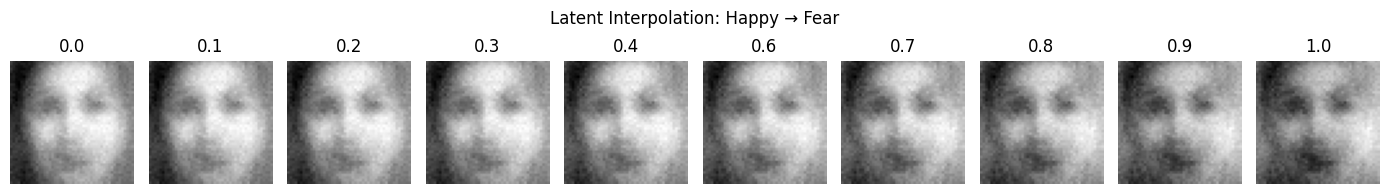

In [72]:
# Plot the sequence from happy → sad
fig, axes = plt.subplots(1, len(interpolated_faces), figsize=(14, 2))
for i, img in enumerate(interpolated_faces):
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"{alphas[i]:.1f}")
plt.suptitle("Latent Interpolation: Happy → Fear", fontsize=12)
plt.tight_layout()
plt.show()


**Interpretation: Why This Matters**

Let’s interpret what we see:

- **Gradual Morphing:** The face transitions smoothly from happy to fear.
You may notice the smile fading, the eyes drooping, and facial features subtly shifting — without abrupt jumps.

- **Continuous Representation:** This smoothness arises because the latent space was trained to resemble a continuous probability distribution.
That’s the core achievement of the VAE — it **learns a manifold** where emotional and geometric features blend naturally.

- **Psychological Resonance:** Emotion in humans isn’t binary — we move fluidly along continua of valence and arousal.
The VAE’s latent space captures a similar intuition, revealing how data-driven learning mirrors human affective perception.

**AE Comparison (Optional)**

To emphasize the benefit of probabilistic latent structure, we can repeat the interpolation using the AE (if available).

You’ll typically observe sharper but less coherent transitions — some intermediate faces may appear distorted or implausible.

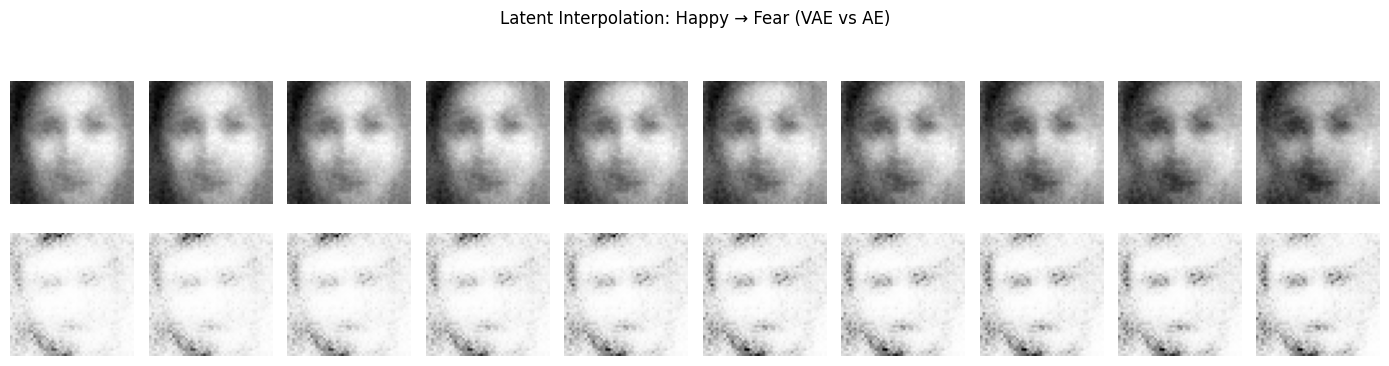

In [73]:
try:
    ae_model.eval()
    with torch.no_grad():
        z_happy = ae_model.encoder(x_happy)
        z_fear = ae_model.encoder(x_fear)
        ae_interpolations = []
        for a in alphas:
            z = (1 - a) * z_happy + a * z_fear
            recon = ae_model.decoder(z).cpu().view(48, 48)
            ae_interpolations.append(recon.numpy())

    fig, axes = plt.subplots(2, len(alphas), figsize=(14, 4))
    for i, img in enumerate(interpolated_faces):
        axes[0, i].imshow(img, cmap="gray"); axes[0, i].axis("off")
    for i, img in enumerate(ae_interpolations):
        axes[1, i].imshow(img, cmap="gray"); axes[1, i].axis("off")
    axes[0, 0].set_ylabel("VAE", rotation=0, labelpad=20)
    axes[1, 0].set_ylabel("AE", rotation=0, labelpad=20)
    plt.suptitle("Latent Interpolation: Happy → Fear (VAE vs AE)", fontsize=12)
    plt.tight_layout()
    plt.show()

except NameError:
    print("AE model not loaded; skipping comparison.")


This experiment highlights the *representational richness* of VAEs.
While the AE merely compresses data, the VAE **learns to organize** it in a meaningful geometric structure — *a map of emotions*.

This property enables downstream tasks like:

- emotion synthesis and blending,
- human-computer interaction design,
- affective computing and digital avatars.

By exploring transitions in latent space, we’re not just visualizing pixels —
we’re visualizing how the model perceives emotion as a continuous spectrum.

---


### **6. Comparing AE vs. VAE Representations**

Having explored how the **VAE organizes and interpolates emotions**, we now step back to compare it with the **Autoencoder (AE)**.  
Both models compress faces into lower-dimensional latent vectors — but the *structure* and *semantics* of these spaces differ profoundly.

This section helps us **quantify and visualize** those differences.

**Conceptual Motivation**

| Aspect | Autoencoder (AE) | Variational Autoencoder (VAE) |
|:-------|:------------------|:-------------------------------|
| Latent representation | Deterministic vector $ z = f(x) $ | Probabilistic distribution $ z \sim \mathcal{N}(\mu, \sigma^2) $ |
| Structure | Scattered, unstructured embeddings | Continuous, Gaussian-like manifold |
| Interpolation | Often abrupt or implausible | Smooth and semantically coherent |
| Generativity | Poor — cannot easily sample new faces | Excellent — sampling from latent prior works well |

> **Key takeaway:**  
> AEs *compress* data; VAEs *model* the data distribution.

In [74]:

import torch
import numpy as np
import matplotlib.pyplot as plt

vae_model.eval()
try:
    ae_model.eval()
except NameError:
    ae_model = None

# Compute latent representations for both AE and VAE
vae_latents = []
ae_latents = []

with torch.no_grad():
    for i in range(0, len(X_val_t), 128):
        xb = X_val_t[i:i+128].to(device)
        mu, _ = vae_model.encode(xb)
        vae_latents.append(mu.cpu())
        if ae_model:
            _, z = ae_model(xb)
            ae_latents.append(z.cpu())

vae_latents = torch.cat(vae_latents).numpy()
if ae_model:
    ae_latents = torch.cat(ae_latents).numpy()

# Compute statistics
print(f"VAE latent mean: {vae_latents.mean():.4f}, std: {vae_latents.std():.4f}")
if ae_model:
    print(f"AE latent mean: {ae_latents.mean():.4f}, std: {ae_latents.std():.4f}")


VAE latent mean: -0.1706, std: 2.0617
AE latent mean: -0.9365, std: 2.6892


**Visualizing Latent Distributions**

Let’s plot histograms to see how the latent vectors are distributed.

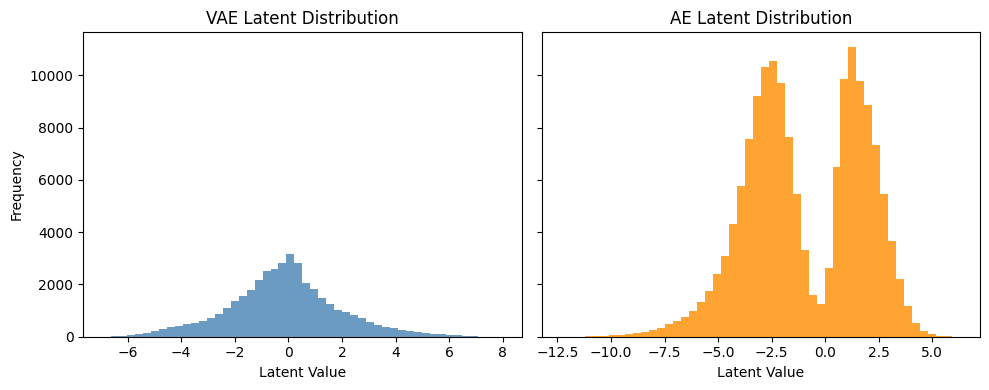

In [75]:
fig, axes = plt.subplots(1, 2 if ae_model else 1, figsize=(10, 4), sharey=True)
axes = np.atleast_1d(axes)

axes[0].hist(vae_latents.flatten(), bins=50, color="steelblue", alpha=0.8)
axes[0].set_title("VAE Latent Distribution")
axes[0].set_xlabel("Latent Value"); axes[0].set_ylabel("Frequency")

if ae_model:
    axes[1].hist(ae_latents.flatten(), bins=50, color="darkorange", alpha=0.8)
    axes[1].set_title("AE Latent Distribution")
    axes[1].set_xlabel("Latent Value")

plt.tight_layout()
plt.show()


**Interpretation:**

- The **VAE histogram** should resemble a smooth bell curve (Gaussian-like).
This means the model has learned a continuous, well-behaved latent prior.

- The **AE histogram** (if available) often looks irregular or multimodal, with clumps or gaps — indicating that latent points aren’t evenly distributed, making interpolation or sampling difficult.

**Qualitative Comparison: Interpolation Smoothness**

We can summarize our earlier interpolation results side by side:

| Property                   | AE                 | VAE                                   |
| -------------------------- | ------------------ | ------------------------------------- |
| Transitions                | Discrete or abrupt | Smooth, gradual, emotionally coherent |
| Intermediate faces         | Often distorted    | Natural morphs between expressions    |
| Latent continuity          | Weak               | Strong                                |
| Suitability for generation | Limited            | Excellent                             |


Let’s consolidate our observations:

- The **AE latent space** is like a messy drawer: you can find what you stored, but nearby items aren’t necessarily related.
- The **VAE latent space** is like an organized library: nearby books (points) share topics — in this case, facial features and emotional tone.

This structured latent space is what empowers VAEs to:

- **interpolate** between emotions smoothly,
- **generate** new, realistic faces by random sampling,
- and **encode** nuanced affective states in a psychologically meaningful way.

The contrast between AE and VAE beautifully illustrates how adding **probabilistic structure** transforms a simple compression model into a **powerful generative system** — one that not only stores but understands patterns in the data.

---

### **7. Reflection — Emotion Continuum**

So far, we’ve visualized, quantified, and traversed the latent space learned by our Variational Autoencoder (VAE).  
Now, let’s pause and interpret *what these results mean* — not in numerical terms, but in **conceptual and psychological terms**.

**From Discrete Labels to Continuous Feelings**

Traditional emotion datasets like **FER2013** label faces as *Angry*, *Happy*, *Sad*, etc.  
However, human emotion is **not categorical** in the way these datasets suggest.  
We don’t instantly jump from *happy* to *sad* — we pass through *neutral* or *ambivalent* states.  

> Our emotional life is **continuous**, not discrete.  
> VAEs, by learning smooth latent manifolds, naturally reflect this truth.

In the VAE’s latent space:
- “Happy” and “Sad” clusters are **not separated by hard boundaries**; they blend softly.  
- The **interpolation paths** we visualized earlier form smooth transitions — resembling how human expressions change in real life.

This continuous geometry is a profound property:  
the VAE doesn’t just *reconstruct faces*, it **models emotional topology** — the *geometry of feeling*.

**Why VAEs Capture Emotion Continuity**

Why do VAEs reflect emotion continuity so effectively?

Because they are **probabilistic**:  
Each face is represented not by a fixed point but by a **distribution** $ \mathcal{N}(\mu, \sigma^2) $.  
This means small variations in latent space correspond to natural, gradual shifts in appearance and affect.

> AEs encode identity; VAEs encode *variability within identity.*

Thus, the model learns that:
- Slightly different latent samples from the same person might reflect small emotional or lighting changes.
- Similar latent regions represent related emotional tones — e.g., *fear* and *surprise* share widened eyes and raised brows, so they **overlap** in the latent manifold.

**Real-World Implications**

This understanding has deep relevance for **emotion-aware AI systems** — areas where modeling the *continuum of affect* matters more than discrete categories.

Examples include:
- **Human–Computer Interaction (HCI):**  
  Adaptive interfaces that sense subtle mood shifts and adjust tone or response style accordingly.
- **Affective Tutoring Systems:**  
  Educational tools that recognize learner frustration or curiosity and adapt guidance dynamically.
- **Digital Wellbeing Applications:**  
  Systems that detect gradual mood declines and offer interventions before users reach negative emotional states.

> The same latent smoothness that allows our VAE to morph faces between emotions  
> could enable *machines to respond empathetically* across emotional gradients.

**Discussion Prompts**

Reflect and discuss:
1. Why do some emotions, like *fear* and *surprise*, overlap in latent space?  
   What does that tell us about the shared physical cues of these emotions?
2. Could such latent representations make machines *too sensitive* to subtle affective cues?  
   What ethical boundaries should be considered?
3. How might continuous emotion modeling improve communication between humans and AI?

**Key Takeaway**

The VAE provides not just a tool for *image generation*,  
but a **computational metaphor** for how emotion itself might be organized —  
as a **smooth manifold** of feelings rather than rigid categories.

> By modeling the *emotion continuum*, we bridge deep learning and affective science — moving from recognizing expressions to understanding *emotional fluidity*.

---

### **8. Applications and Future Directions**

With this final section, we’ll connect what we’ve learned about **latent representations** and **emotion manifolds** to broader real-world applications — and prepare to move toward **adversarial generative models (GANs)** in our next stage.

**From Research Insight to Practical Impact**

Our exploration of VAEs revealed that they don’t just compress or reconstruct —  
they **understand structure**, **model variability**, and **generate coherent data**.  
These qualities make them foundational in several fields where human affect and visual synthesis intersect.

Let’s explore a few domains where this understanding of latent space translates directly into innovation.

**Key Application Domains**

**🧠 Human–Computer Interaction (HCI):**  
- VAEs can help design interfaces that *perceive and adapt* to users’ emotions.  
- Imagine a virtual assistant that detects subtle shifts in your mood from facial cues and adjusts tone or recommendations accordingly.  
- By learning smooth affective manifolds, systems can respond appropriately — *not just classify*.

**💬 Affective Computing:**  
- Emotional states are rarely binary.  
- VAEs provide a framework to **detect subtle affective changes** over time rather than abrupt category switches.  
- In emotion recognition or empathy-driven chatbots, this continuous understanding enhances *authentic interaction*.

**🎭 Content Generation & Digital Art:**  
- Artists and designers can *sample from latent space* to create new, mood-consistent avatars or stylized portraits.  
- Latent interpolation (like we did with “happy → sad”) can be used to animate expressions, enhance realism in games, or design emotionally expressive virtual humans.  
- VAEs thus act as *creative collaborators* — generating diverse, emotionally coherent outputs.

**🧩 Psychological and Behavioral Modeling:**  
- VAEs can help researchers visualize affective dimensions such as **valence** (positive ↔ negative) and **arousal** (calm ↔ excited).  
- Mapping these dimensions in latent space could offer a *computational model of emotion* — bridging psychology, neuroscience, and machine learning.  
- This has potential in therapy simulations, mental health monitoring, and digital wellbeing analytics.

**The Broader Significance**

> VAEs move us beyond “data fitting” toward **representation learning** —  
> understanding *why* data varies, not just *how*.

Their probabilistic nature makes them not only better generators but also *better learners of meaning*.  
Each dimension in the latent space can correspond to interpretable changes:  
eye shape, smile intensity, lighting, or even emotion type — a key step toward **interpretable AI**.

**Looking Ahead — From VAEs to GANs**

Our journey through Autoencoders (AEs → VAEs) has given us a strong foundation in **unsupervised generative learning**.

But there’s more to come.

The next chapter introduces **Generative Adversarial Networks (GANs)** — models that bring *competition* into learning:  
- A **Generator** tries to create realistic data.  
- A **Discriminator** tries to detect fakes.  
Through this adversarial training, GANs push realism to new heights.

> If VAEs teach us how to represent emotion space,  
> GANs teach us how to **create with realism and intent**.

**Key Takeaways**

- VAEs extend Autoencoders by **modeling distributions**, not just codes.  
- Their latent spaces naturally reflect **emotional and structural continuity**.  
- They enable applications in **HCI**, **affective computing**, **creative generation**, and **psychological modeling**.  
- The path forward — **GANs** — will build on these foundations to achieve *photorealistic* synthesis.

> 🧭 *In essence, VAEs gave us the map of the human face’s emotional landscape.  
> GANs will teach us how to paint within it — vividly, dynamically, and convincingly.*

---
